In [87]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from IPython.display import HTML

In [88]:
# Constants and variables
BATCH_SIZE = 32
IMG_SIZE = 256
CHANNELS = 3
EPOCHS = 50
SEED = 123

In [89]:
# Load dataset
data_dir = "Potato Leaf Disease Dataset"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=SEED,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 3076 files belonging to 7 classes.


***Showing The Class Names From The Dataset***

In [90]:

class_names = dataset.class_names
print(class_names)

['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


***Displaying The Shape Of One Batch Of Images By Labeling Them***

In [91]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 0 3 6 0 6 4 1 6 6 1 4 0 4 5 2 6 2 1 4 6 3 1 1 2 0 4 3 0 2 3 4]


***Plotting Sample Images From Dataset***

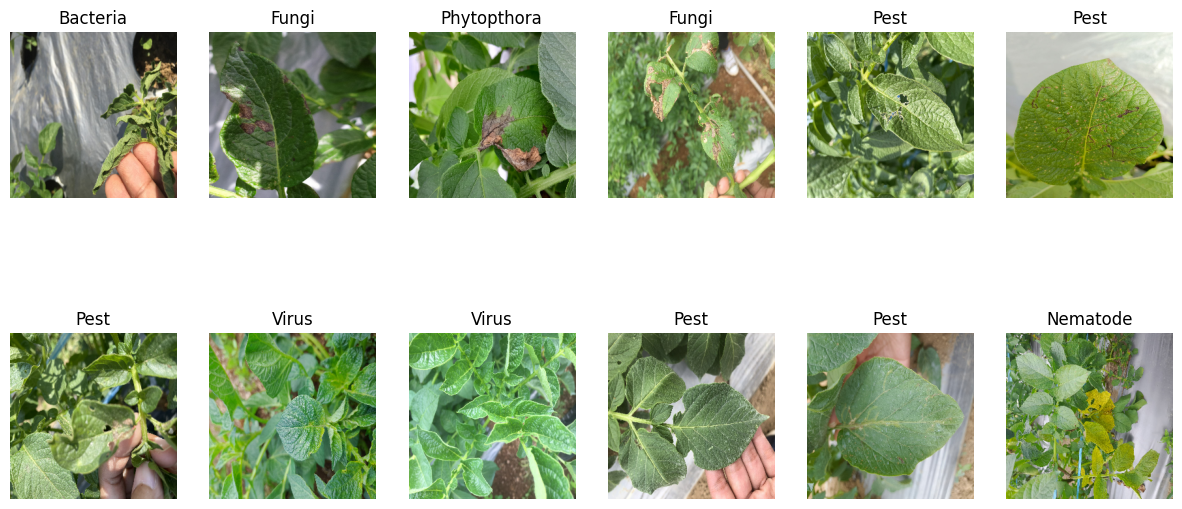

In [92]:

plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()

***Splitting Dataset into Training and testing and validation***

In [95]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Training set size: {len(train_ds)}")
print(f"Validation set size: {len(val_ds)}")
print(f"Test set size: {len(test_ds)}")

Training set size: 77
Validation set size: 9
Test set size: 11


***Performance Optimization ***

In [96]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

*** DATA PREPROCESSING AND AUGMENTATION ****************

In [97]:

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

***Defining The MODEL***

In [99]:

input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
num_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax'),
])

model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, CHANNELS))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,007 (718.78 KB)

 Trainable params: 184,007 (718.78 KB)

 Non-trainable params: 0 (0.00 B)

***MODEL COMPILATION ***

In [100]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [102]:
# Train model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 52s 675ms/step - accuracy: 0.1915 - loss: 1.9024 - val_accuracy: 0.1597 - val_loss: 1.7968
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 47s 606ms/step - accuracy: 0.2041 - loss: 1.8357 - val_accuracy: 0.2674 - val_loss: 1.7982
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 47s 605ms/step - accuracy: 0.2457 - loss: 1.8174 - val_accuracy: 0.2986 - val_loss: 1.7085
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 49s 627ms/step - accuracy: 0.2499 - loss: 1.8104 - val_accuracy: 0.3194 - val_loss: 1.6574
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 49s 631ms/step - accuracy: 0.2953 - loss: 1.7184 - val_accuracy: 0.3507 - val_loss: 1.6381
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 48s 616ms/step - accuracy: 0.3043 - loss: 1.6920 - val_accuracy: 0.3438 - val_loss: 1.6216
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 51s 662ms/step - accuracy: 0.3165 - loss: 1.6823 - val_accuracy: 0.3472 - val_loss: 1.5244
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 50s 646ms/step - accuracy: 0.3150 - loss: 1.6325 - val_accu

In [103]:
# Evaluate model
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.6871 - loss: 0.8735
Test Loss: 0.8899492621421814
Test Accuracy: 0.6903409361839294


Total Training Accuracy: 0.48
Total Validation Accuracy: 0.48


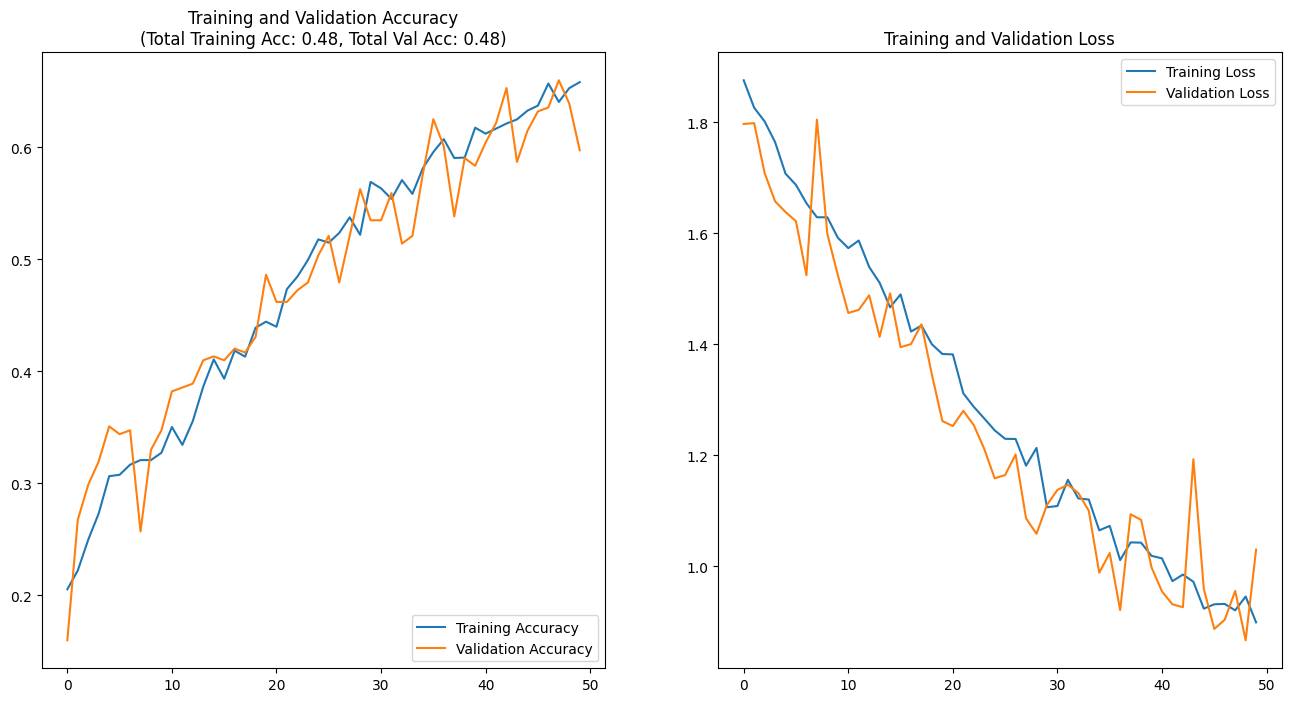

In [104]:
import matplotlib.pyplot as plt



# Extracting history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculating total (mean) training and validation accuracy
total_training_acc = sum(acc) / len(acc)
total_val_acc = sum(val_acc) / len(val_acc)


print(f'Total Training Accuracy: {total_training_acc:.2f}')
print(f'Total Validation Accuracy: {total_val_acc:.2f}')

# Plotting training & validation accuracy and loss

plt.figure(figsize=(16, 8))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy\n(Total Training Acc: {total_training_acc:.2f}, Total Val Acc: {total_val_acc:.2f})')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [85]:
import numpy as np
from sklearn.metrics import classification_report, average_precision_score

y_true = []
y_pred = []
y_scores = []  # Predicted scores for calculating AP
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    y_scores.extend(predictions)

class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)

# Calculate mAP
average_precision = average_precision_score(np.array(y_true), np.array(y_scores), average=None)
mAP = np.mean(average_precision)
print(f'Total mAP: {mAP:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
              precision    recall  f1-score   support

    Bacteria       0.40      0.80      0.54        65
       Fungi       0.27      0.61      0.37        82
     Healthy       0.00      0.00      0.00        17
    Nematode       0.00      0.00      0.00         3
        Pest       0.22      0.08      0.12        71
 Phytopthora       0.00      0.00      0.00        46
       Virus       0.38      0.04      0.08        68

    accuracy                           0.32       352
   macro avg       0.18      0.22      0.16       352
weighted avg       0.25      

c:\Users\sayed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sayed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sayed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

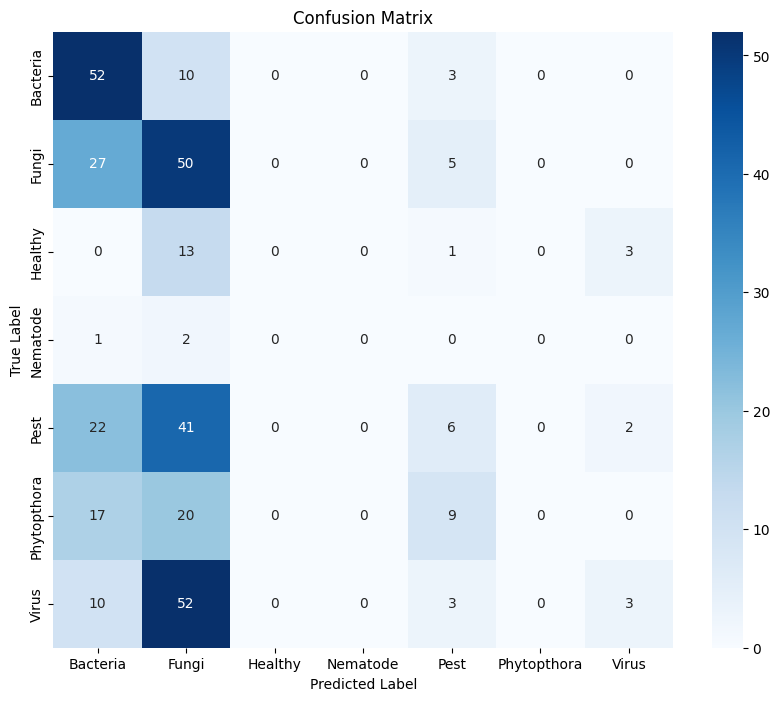

In [86]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


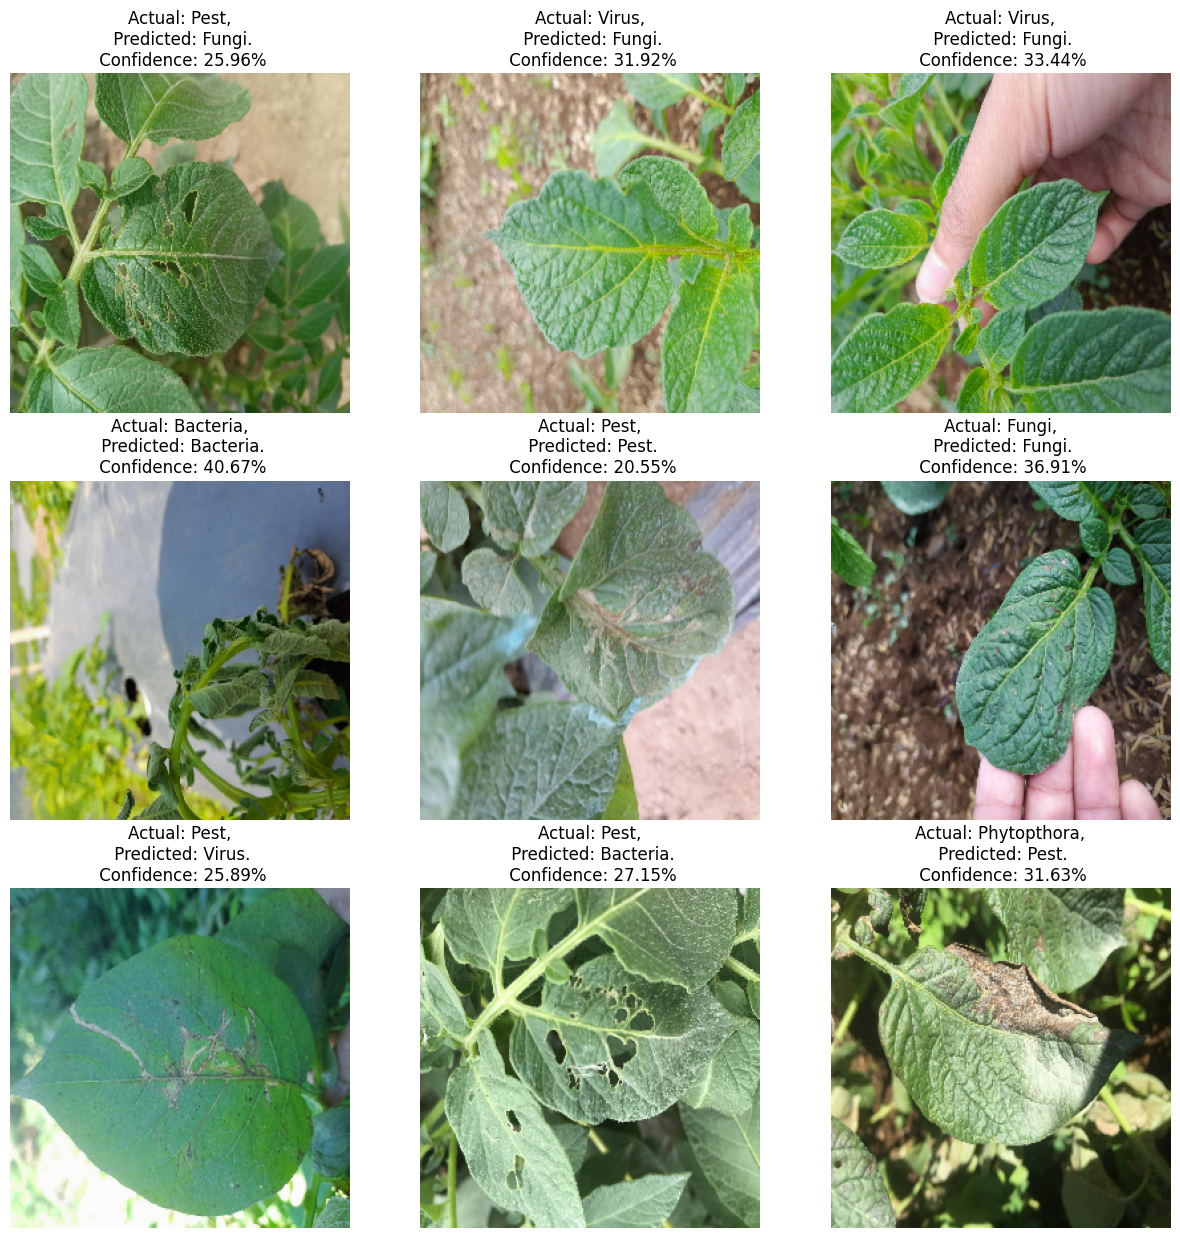

In [80]:
# Display sample predictions
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
plt.show()